# Special Applications: Face Recognition & Neural Style Transfer

## What is Face Recognition?

Ref paper: https://arxiv.org/pdf/1503.03832.pdf


Verification: Given an image and an id, determine whether the image belongs to that person.

Face Recognition: Given an image and a database of images, determine who the image belongs to (if any).

To have low error rate on face verification system you have so that your face recognition system perform well. Since if your DB has 100k examples, even verification model with 99% accuracy would make a lot of mistakes!!



## One-Shot Learning

- Recognize a person given one reference image!! DNNs don't really work super well historically.

(bad) One approach:

- Input image to CNN output softmax with N classes (N is the number of people in your DB)
- Bad approach since your training data will have very sparse data one sample for each class
- What if new member joins the team? Re-train the net?


Better approach:

- Learn a similarity function d(img1,img2)
- input two images output degree of difference between images
- If difference $d$ is smaller than a threshold output "same" and different otherwise
- So it will be a pairwise comparison problem.


## Siamese Network


- Given an input image lets have a ConvNet that encodes the image into 128-dim embedding
    - $f(x^{(1)})$
- Do the same for both images.
    - $f(x^{(2)})$
- So you have two 128 embs 
- Define the distance as $d(x^{(1)},x^{(2)})=\lVert f(x^{(1)}) - f(x^{(2)})\rVert_2^2$


Learn params so that:
- If same person d should be minimizes
- If different people than maximize

## Triplet Loss

How to define an objective function?? 

- You will have three samples at each time:
    - Anchor image (A)
    - Positive image (P) (same person)
    - Negative image (N) (different person)
 
So we want:

$$
d(A,P) - d(A,N) \leq \alpha
$$
where $\alpha$ is called the margin. We want at least $\alpha$ separation given a positive image, a negative image and the anchor.

Important to note that if you don't have $\alpha$ (and just have $\leq 0$) the neural network would collapse to outputting zero vector or identical vector for all inputs.

The above point is a great example on the importance of defining the objective functions accurately.



**Triplet loss definition**

Given 3 images A,P,N:

$$
L(A,P,N) = max(\lVert f(A) - f(P)\rVert_2^2 - \lVert f(A) - f(N)\rVert_2^2 + \alpha,0)\\
J = \sum_i L(A_i,P_i,N_i)
$$

Overall cost is just a sum over all triplets.

Training set 10k pictures of 1k persons

- Use your dataset to generate the triplets A, P, N (so probably you need multiple pictures for each person so you have different A and P!!)

### How do you choose $A_i,P_i,N_i$? 

- During training, if they are chosen randomly, our constraint is easily satisfied actually (very easy task):
$$
d(A,P) + \alpha \leq d(A,N)
$$
Imagine picking an elephant picture for negative image where anchor is a specific cat in your animal face recognition. Negative images should be the face of another image probably!

- However what you want is to choose triplets that are hard to train on so you can learn the subtleties.


So we should actually choose negative samples and positive such that the differences between the anchor are actually similar.



## Face Verification and Binary Classification

We saw triplet loss as a way to build a verification system. 

We can also pose the problem as a binary classification task.

- Consider your two networks (siamese network) generating two embeddings (one for each image). 

- Combine the two embeddings into a single hidden unit and have sigmoid activation for binary prediction.


Instead of using the two embeddings separately, use their differences:

$$
emb_1 = f(x^{(i)})\\
emb_2 = f(x^{(j)})\\
\hat{y}  = \sigma  (\sum_{d=1}^{128} w_d |emb_{1d} - emb_{2d}| + b)
$$

So the siamese network means the two networks actually share the parameters!!

Good idea:

- For your images in your database, save time by precomputing the vectors for your images in your database. So during inference, when new person comes, we just calculate the vector of the new image and compare with the precomputed vectors.

## What is Neural Style Transfer?

Fun application of ConvNets!! 

What is neural style transfer?? 

- (C) Content: Image you want to recreate
- (S) Style: Image which has the style in which you want to generate content in (example S is picasso painting)
- (G)Generated image

In order to do neural style transfer, we need the embeddings from multiple levels of the ConvNets. Each level actually capture different information about features and details.

## What are deep ConvNets learning?

Some visualizations to understand. Image from lecture below.

- Pick unit in layer 1. Find nine image patche that maximize the unit's activation! 
    - If they all look like some edges, we can say that unit is catching the edges.
    - All units might be detecting different stuff including colors patterns etc. etc.

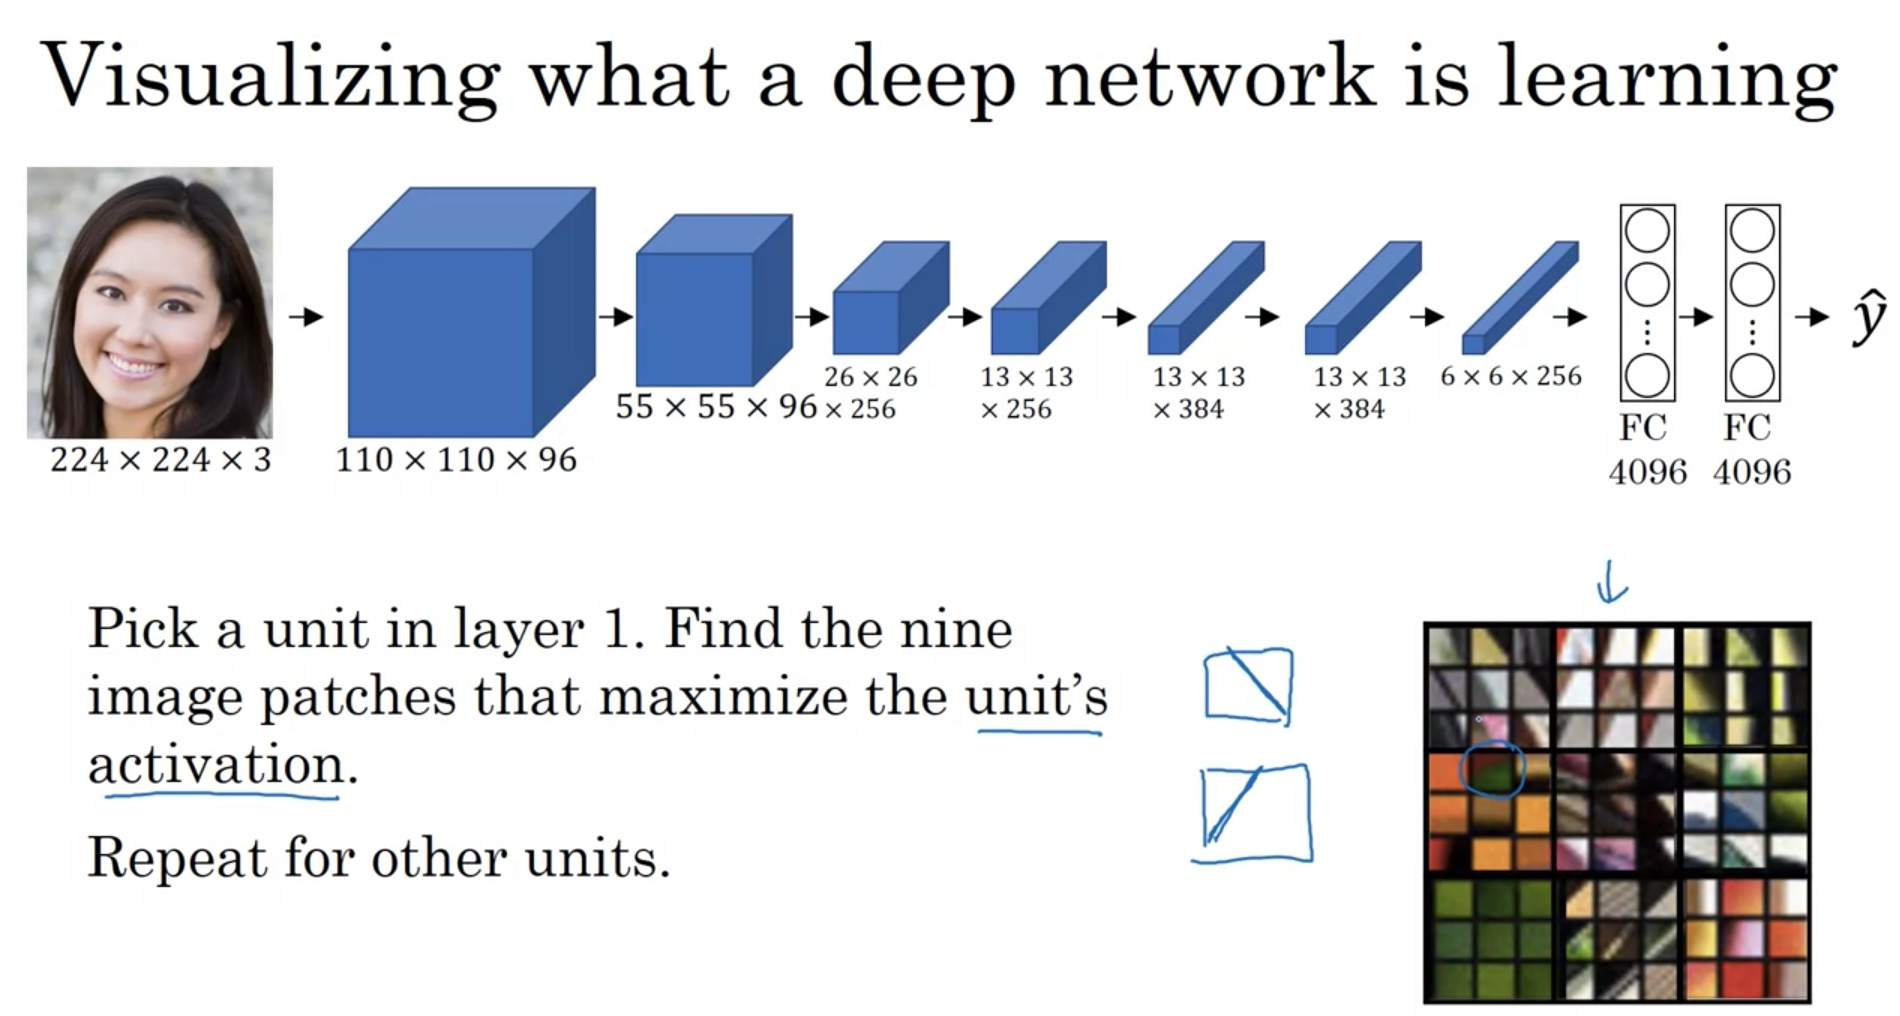

In [1]:
from IPython.display import Image
Image(filename='../../assets/visualize_convnet.jpg')


- Let's repeat this for deeper layers, not just layer 1.

- 9 hidden units are chosen and for each we display 9 examples that activate them the most.

- As we go deeper, the patterns get quite complex



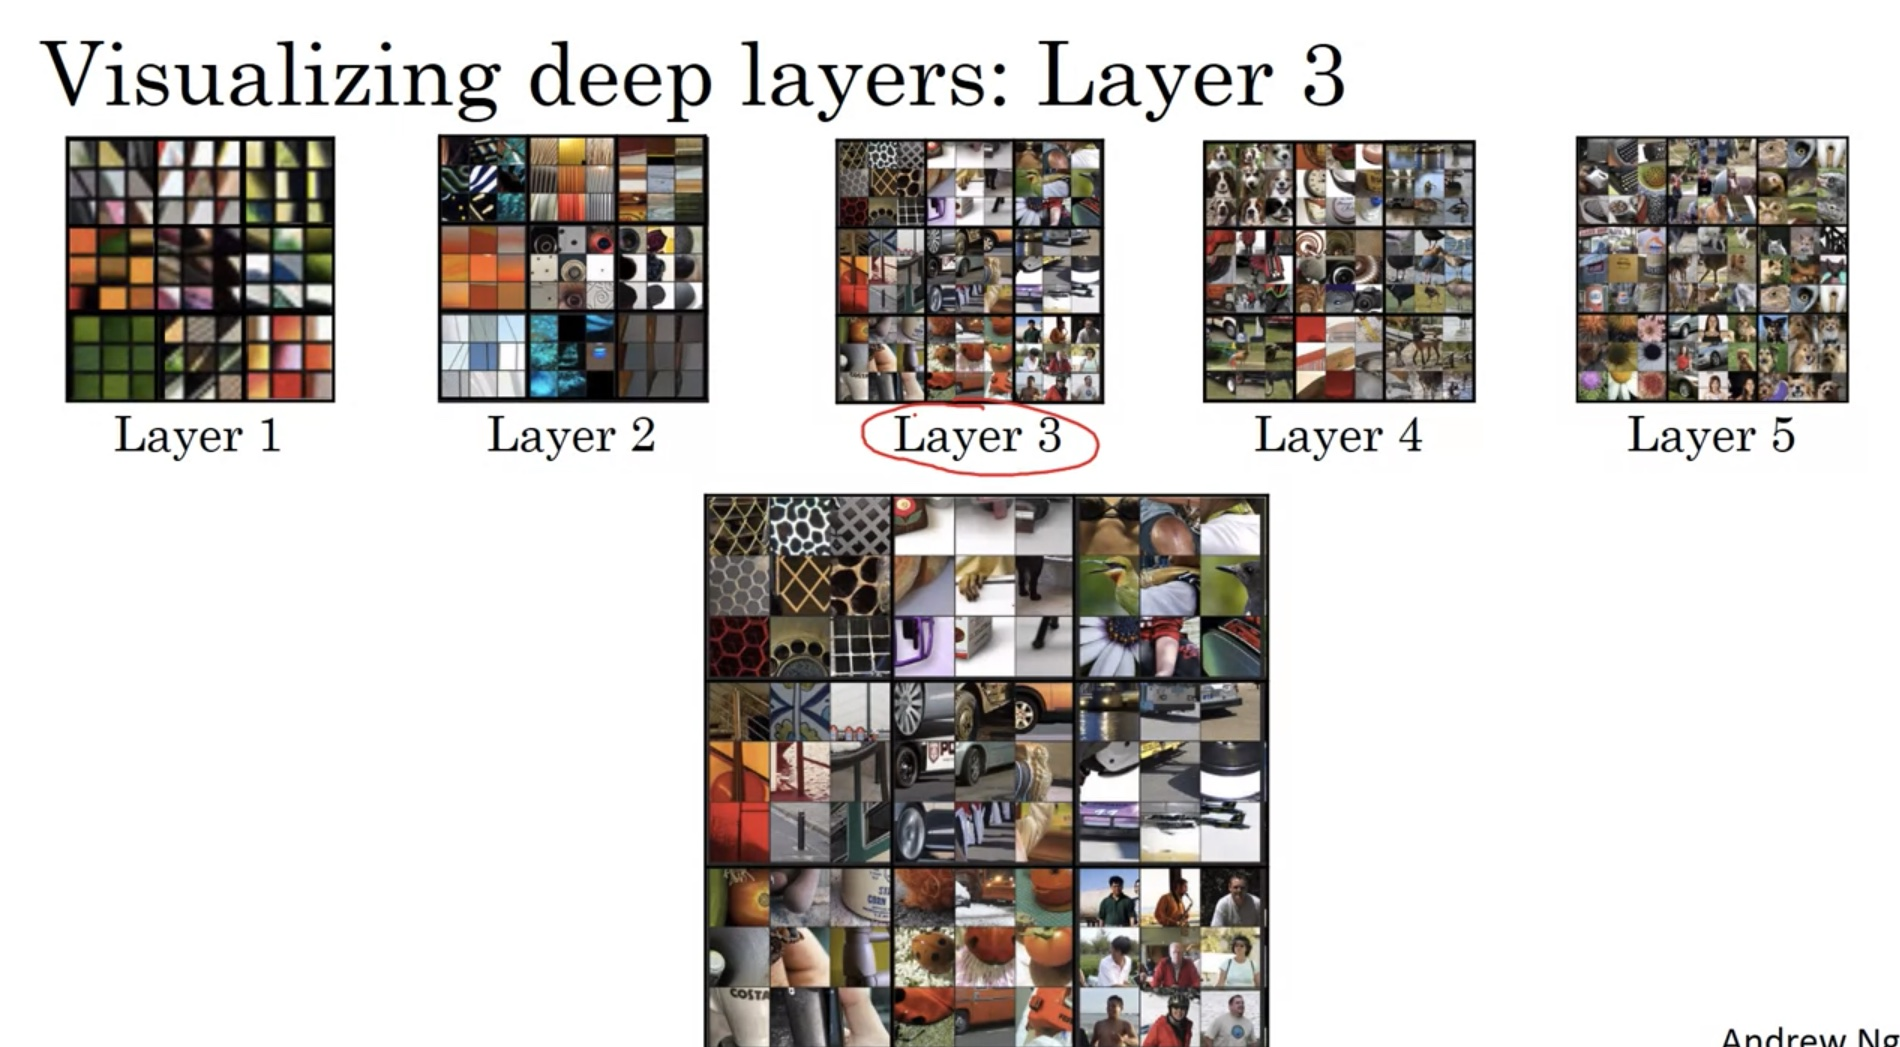

In [3]:
Image(filename='../../assets/alllayer_vis_convnvet.jpg')


## Cost Function for Neural Style Transfer

Reference paper: https://arxiv.org/pdf/1508.06576.pdf

Let's use this intuitions from the visualizations to define a cost function.

- We need to define $J(G)$ that measure the cost of the generated image.

$$
J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)
$$


Algorithm:

1. Initialize G randomly 100x100x3
2. Use gradient descent to minimize $J(G)$

The core idea is the network is fixed and we apply gradient descent on the input image!!

So 

$$
G_t = G_{t-1} - \alpha \dfrac{d}{dG_{t-1}} J(G)
$$

where $\dfrac{d}{dG_{t-1}}J(G) $ the gradient of the cost function with respect to the generated image..

One question I have is why not initialize the G image with one of the inputs?? Maybe it hurts the performance? 

### Content Cost Function

$J_{content}(C,G)$


- Say you use hidden layer $l$ to compute content cost.
- $l$ should be neither 1 nor last layer since we want something in between.
- Use a pre-trained ConvNet e.g. VGG 
- Get the activations from layer l and compare the activations from that layer for both images.

$$J_{content}(C,G) = \dfrac{1}{2} \lVert a^{[l](C)} - a^{[l](G)}\rVert_2^2$$

elementwise sum of squared differences.


## Style Cost Function

What does the style of an image mean?

- Pick a layer l
- Define style as correlation between activations across channels (many channels in intermediate layer)!!


Why correlation capture style??

Makes sense because, it captures that if pattern A cooccur with pattern B (patterns are activations in deep layers).

**Style Matrix** $G^{[l]}$ which is of size $n_c^{[l]}$ by $n_c^{[l]}$

G is used because in math the below matrix is also called a "gram matrix".

So given the generated image, we could calculated its style matrix as follows:

$$
G_{(k,k{'})}^{[l](G)} = \sum_i^{n_h^{[l]}} \sum_j^{n_w^{[l]}} a_{(i,j,k)}^{[l](G)} a_{(i,j,k^{'})}^{[l](G)}
$$

$(G)$ denotes that this activation is for the generated image.

- In total we can fill all cells of $G^{[l](G)}$ in this way by looping over all channels twice.

- The idea is that $i,j$ denote a certain bounding box in the original sized image. If two channels (a,b) have high activation on that same box, it suggests image has the style (a,b) in that point.

Next we can define the style cost for one layer as follows:

Calculate the style matrix for the Style image.
$$
G_{(k,k{'})}^{[l](S)} = \sum_i^{n_h^{[l]}} \sum_j^{n_w^{[l]}} a_{(i,j,k)}^{[l](S)} a_{(i,j,k^{'})}^{[l](S)}
$$

Cost function for one layer:

$$
J_{style}(G,S)^{[l]} = C \sum_k \sum_{k^{'}} ( G_{(k,k{'})}^{[l](S)} - G_{(k,k{'})}^{[l](G)})^2
$$

where $$C= \dfrac{1}{2n_H^{[l]} n_W^{[l]} n_c^{[l]}}$$


Next, Authors report that instead of comparing the style for one layer, it is better to calculate over multiple layers since they detect different hierarchies of style:

$$
J_{style}(S,G) = \sum_l \lambda^{[l]} J(G,S)_{style}^{[l]}
$$

how to pick the right values for $\lambda$ is something we have to figure out.

Overall we combine both cost functions:


$$J(C,S,G) = J_{content}(C,G) + J_{style}(S,G)$$

## Convolutions in 1D and 3D

Well just apply sliding window over the 1D input...

14 1D input with filter of length 5 you get 10 1D output..



What is 3D image?

Great example is the 3D scan where each cross section is one image of a slightly deeper layer into your torso.

